# Tutorial 2: basic usage
In this tutorial, we apply DDN to two simple synthetic datasets, which is generated under two different network structures.
After DDN detects the two networks, we visualize the common and differential networks, as well as getting the edges in each network.
Since we use synthetic data in this example, we can compare the DDN results with groud truth. We can also study the impact of different hyper-parameters.

Comparing with the previous demo, we go into slightly more details, and do not use the `pipeline` module.

First we need to import some modules. The `ddn` packages implements the DDN 3.0 algorithm. The `tools_export` modules provides functions for generating useful outputs.
The `visualize` module provides some simple function to draw the networks based on the `networkx` package.

The `tools`, `simulation`, and `performance` modules are used here to generate synthetic data and evaluate performance.
They are not needed if you are working on a real dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ddn3 import ddn, tools_export, visualize
from ddn3 import tools, simulation, performance

%load_ext autoreload
%autoreload 2

## Preparing the data
DDN needs two datasets as input, as well as a list of gene names for output and visualization.
Each dataset should be a NumPy array. Each row of the array represent a sample, and each column represent a feature (like genes).
The two datasets may have different number of samples, but must have the same number of features.

Here we generate two synthetic datasets, `dat1` and `dat2`. They are generated based on a common graph with 40 nodes.
There are 20 edges in this graph, connecting node0 with node20, node1 with node21, etc.
The two conditions are created by shuffling five of the edges in common network.
Each condition has 100 samples. The names of genes are given in `gene_nemas`.

We define the common network is the set of all edges that is present in both conditions, and the differential network as the set of edges that present in only one of the conditions.
The ground truth common and differential network in this synthetic data is saved in `comm_gt` and `diff_gt`.

In [2]:
n_node = 40
n_sample1 = 100
n_sample2 = 100
n_shuf = 5
g1_prec, g2_prec = simulation.create_pair_graph(n_node=n_node, corr=0.75, n_shuf=n_shuf)
comm_gt, diff_gt = tools.get_common_diff_net_topo([g1_prec, g2_prec])

We give some arbitrary names to these features.

In [3]:
gene_names = [f"Gene{i}" for i in range(n_node)]

The data is generated by sampling the covariance matrix of each condition.

In [4]:
g1_cov, _ = simulation.create_cov_prec_mat(g1_prec)
g2_cov, _ = simulation.create_cov_prec_mat(g2_prec)
dat1 = tools.gen_mv(g1_cov, n_sample1)
dat2 = tools.gen_mv(g2_cov, n_sample2)

## Running DDN 3.0 and visualize the networks

DDN requires two hyper-parameters, $\lambda_1$ and $\lambda_2$. 
Here $\lambda_1$ controls the overall sparsity of the two networks, and $\lambda_2$ controls the similarity betwwen the two graphs.
The typical value of $\lambda_1$ is between 0.1 and 0.8, while $\lambda_2$ is between 0.02 and 0.2.
In this dataset, $\lambda_1=0.3$ and $\lambda_2=0.1$ turns out to be a good choice, as we have the ground truth network structure.

In real applications, it is advised to utilize the prior knowledge to determine the desired density of the graphs.
Specifically, one may run DDN with a range of $\lambda_1$s and $\lambda_2$s, and pick the network that is most usable.
Alternatively, we provide various functionalities of hyperparameter setting, and we cover that topic in `demo_parameter_tuning.ipynb`.

The first time you run DDN 3.0, it takes a short time for Numba to compile the code. If you run it again later, it will be much faster.

The output of DDN is two coefficient matrices, one for each condition. For a graph with $N$ features, each matrix has dimension $N\times N$.
The value of element in row $i$ and column $j$ means the estimated coefficient between the $i$ th feature and the $j$ th feature.
If the value is non-zero, it implies there could be dependencies between these two features.

In [5]:
omega1, omega2 = ddn.ddn(dat1, dat2, lambda1=0.3, lambda2=0.1)

In [16]:
# np.savez(
#     "two_part_network.npz",
#     dat1=dat1,
#     dat2=dat2,
#     omega1=omega1,
#     omega2=omega2,
#     lambda1=0.3,
#     lambda2=0.1,
#     g1_prec=g1_prec,
#     g2_prec=g2_prec,
#     g1_cov=g1_cov,
#     g2_cov=g2_cov,
# )

We can then extract common and differential networks from two estimated coefficient matrices.
As DDN use regression to learn the dependency of each node with all other nodes, the coefficient matrix is not necessarily symmetric.
For each matrix, we take the average with its transpose to make it symmetric. Then we apply a very small threshold to eliminate too small values.
The resulting matrix is binarized as the adjacency matrix. Then we extract common and differential networks from these two adjacency matrices.

All these tasks can be performed using the `get_diff_comm_net_for_plot` function in the `tools_export` module.
The output `comm_edge` is a pandas data frame that reports edges in both networks. The also provides `weight` for each edge.
The output `dif1_edge` provides edges that only present in condition 1 (`dat1`), and `dif2_edge` provides edges that only present in condition 2 (`dat2`).
The `diff_edge` combines `dif1_edge` and `dif2_edge`, and is the differential network we refer to later.
The `node_non_isolated` list the gene names that are not isolated in either common or differential networks. 
In other words, it includes nodes that has at least a neighbor. This list can be useful for visualization, as it eliminates many irrelevant nodes.

In [6]:
comm_edge, dif1_edge, dif2_edge, diff_edge, node_non_isolated = tools_export.get_diff_comm_net_for_plot(omega1, omega2, gene_names)

The data frames `comm_edge`, `dif1_edge`, `dif2_edge` and `diff_edge` also provides the weigth of the edge. 
Here we use the absolute value of the coefficient as the weight.
In `diff_edge`, to distinguish edges from two conditions, a `condition` column is included.

In [7]:
diff_edge

,gene1,gene2,condition,weight
0,Gene20,Gene0,1,0.351984
1,Gene21,Gene1,1,0.430088
2,Gene22,Gene2,1,0.312646
3,Gene23,Gene3,1,0.386798
4,Gene24,Gene4,1,0.276053
0,Gene20,Gene1,2,0.379670
1,Gene21,Gene2,2,0.390149
2,Gene22,Gene3,2,0.274102
3,Gene23,Gene4,2,0.318920
4,Gene24,Gene0,2,0.285407


We can plot the common networks using the `draw_network_for_ddn`function in the `visualize` module.
The function requires the `comm_edge` data frame, as well as the list of gene names.
For common networks, we need to set `mode="common"`.

The size of the node will represent the degree of each node. The thickness and darkness of the edge will represent the edge weight.
In this synthetic data, all nodes have same degree and all edges have the same weigth, so the node sizes and edge thickness are the same.

To adjust figure size, font size, or node size, you may change the correspoding parameters in the function.

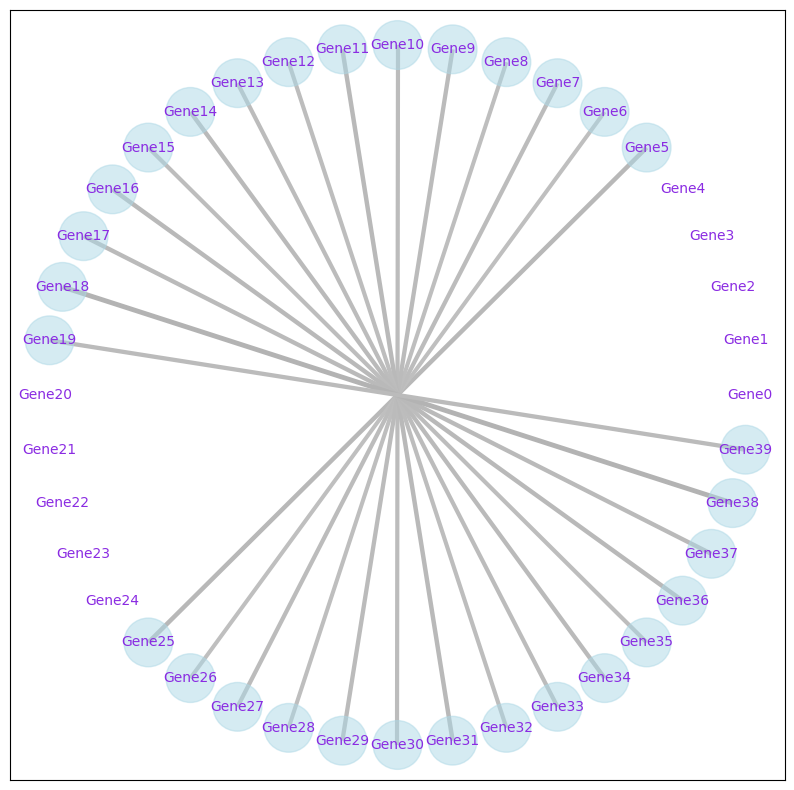

In [8]:
visualize.draw_network_for_ddn(
    comm_edge,
    node_non_isolated,
    fig_size=10,
    font_size_scale=1,
    node_size_scale=1,
    part_number=1,
    mode="common",
    export_pdf=False,
)

Similarly, we can visualize the differential network. The blue edges means that the edge only occurs in condition 1. The blue edge means it only occurs in condition 2.

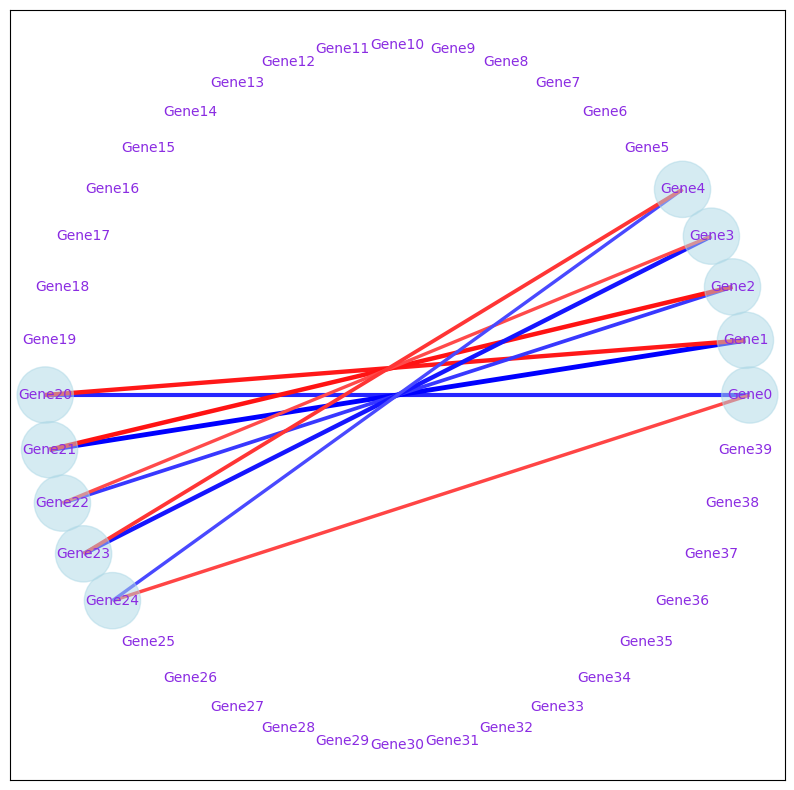

In [9]:
visualize.draw_network_for_ddn(
    diff_edge,
    node_non_isolated,
    fig_size=10,
    font_size_scale=1,
    node_size_scale=1,
    part_number=1,
    mode="diff",
    export_pdf=False,
)

## Evaluate the performance against ground truth
We can quantitatively evaluate the performance of DDN on this synthetic data.
As discussed above, we first need to modify the coefficient matrices to the common and differential network adjacency matrices.
Then we can compare them with the groud truth.

The function `get_error_measure_two_theta` gives five performance measures:
true positive, false positive, true positive rate, false positive rate, precision.
As can be seen, for this data, the results are perfect, with all edges correctly detected and no false positive is included.
Note that due to randonness in the data, it is possible to observe some small errors.

In [10]:
comm_est_ddn, diff_est_ddn = tools.get_common_diff_net_topo([omega1, omega2])
eval_comm = performance.get_error_measure_two_theta(comm_est_ddn, comm_gt)
eval_diff = performance.get_error_measure_two_theta(diff_est_ddn, diff_gt)
print("Performance measures: true positive, false positive, true positive rate, false positive rate, precision")
print("Common network ", eval_comm)
print("Differential network ", eval_diff)

Performance measures: true positive, false positive, true positive rate, false positive rate, precision
Common network  [15.  0.  1.  0.  1.]
Differential network  [10.  0.  1.  0.  1.]


We can plot the estimated and the ground truth adjacency matrix of common network (we removed the diagonal elements).
By comparing the two figures, we can confirm the results are correct.

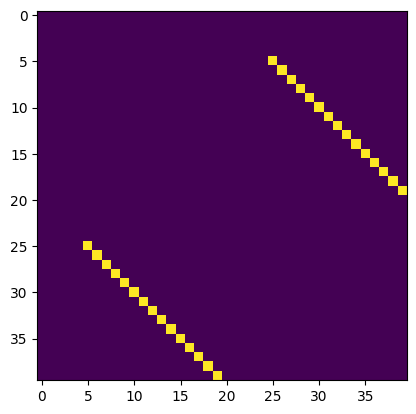

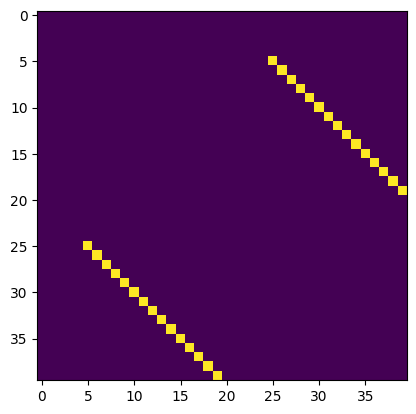

In [11]:
plt.imshow(comm_est_ddn)
plt.show()
plt.imshow(comm_gt)
plt.show()

We can also plot the estimated and the ground truth adjacency matrix of differential network (we remove the diagonal elements).
In this data, the results are also correct.

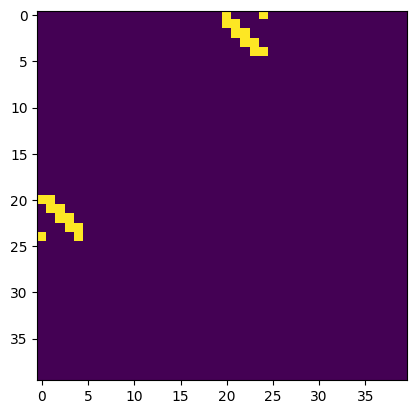

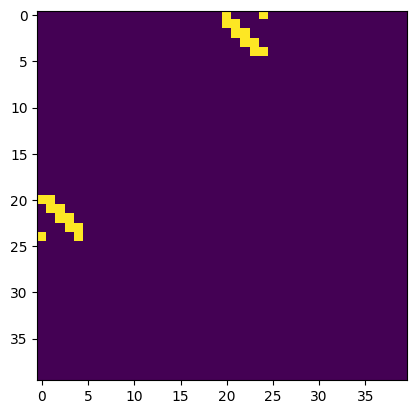

In [12]:
plt.imshow(diff_est_ddn)
plt.show()
plt.imshow(diff_gt)
plt.show()

## Study the impact of $\lambda_1$
We can also study the performance of DDN under different $\lambda_1$ values.
We start from a small value of 0.02, and go all the way to 1.0, with a step size of 0.02.
This can be achieved by writing a simple `for` loop.

In [13]:
lambda1_rg = np.arange(0.02, 1.01, 0.02)
res_comm_ddn = np.zeros((len(lambda1_rg), 5))
res_diff_ddn = np.zeros((len(lambda1_rg), 5))
for i, lamb in enumerate(lambda1_rg):
    out_ddn = ddn.ddn(dat1, dat2, lambda1=lamb, lambda2=0.1)
    comm_est, diff_est = tools.get_common_diff_net_topo(out_ddn)
    res_comm_ddn[i] = performance.get_error_measure_two_theta(comm_est, comm_gt)
    res_diff_ddn[i] = performance.get_error_measure_two_theta(diff_est, diff_gt)

We plot the number of ture positive edges in the common network as a function of $\lambda_1$.
It is clear that for smaller $\lambda_1$ values, all common edges are detectd.
With larger $\lambda_1$, more and more edges are lost due to stronger penalization, and ultimately no edges are detected.

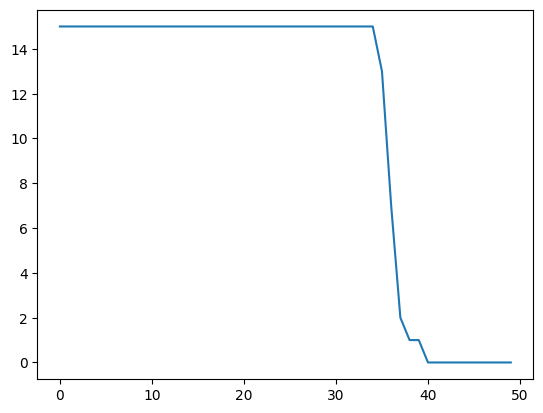

In [14]:
plt.plot(res_comm_ddn[:,0])

We can also plot the number of ture positive edges in differential network as a function of $\lambda_1$.
The condition is somewhat different. When $\lambda_1$ is too small, differential edges are not well detected, as many of them are just considered as common edges.
Larger $\lambda_1$ help to revealt these differential edges.

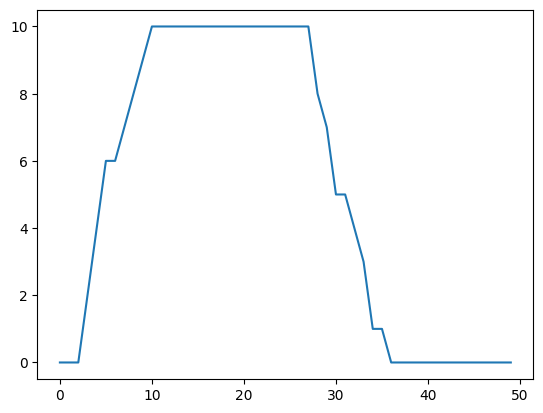

In [15]:
plt.plot(res_diff_ddn[:,0])

The choie of $\lambda_2$ also influence the performance. We do no show it here, but you are free to try.
The effects will be more clear with a smaller sample size.